# Feature Prototype Sentiment Analysis

Data: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

#### Evaluation methodology

The sentiment analysis model will be evaluated using several metrics, including accuracy, precision, and recall. These metrics will be calculated by comparing predicted sentiments with the actual sentiments in the dataset. In order to obtain the accuracy metric, we will count the percentage of correctly classified sentiments. This will provide us with a clear indication of how well the model is performing. However, it is not enough to rely only on the accuracy metric. We also need to assess the precision and recall metrics. The precision metric will measure the proportion of correctly classified positive sentiments out of all positive classifications.

$$ Precision = {True Positive(TP) \over True Positive(TP) + False Positive(FP)} $$ 

Similarly, the recall metric will measure the proportion of correctly classified positive sentiments out of all actual positive sentiments. This metric will help us understand how well the model is identifying positive sentiments.

$$ Recall = {True Positive(TP) \over True Positive(TP) + False Negative(FN)} $$

Finally, the F1 score will be used to balance the precision and recall metrics. This score will take into account both the precision and recall metrics and provide us with an overall score that reflects the performance of the model. 

$$ F1 = 2 * {Precision(P) * Recall(R) \over Precision(P) + Recall(R)} $$


It is important to note that the evaluation metrics used in this project are for academic purposes. The insights gained from this evaluation process can potentially be applied to real-world scenarios and improve sentiment analysis models in various industries.

##### Libraries

In [2]:
!pip install transformers

In [2]:
import numpy as np 
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('all-data.csv', encoding='unicode_escape', names=['Sentiment', 'Text'])
df.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


<AxesSubplot:xlabel='Sentiment'>

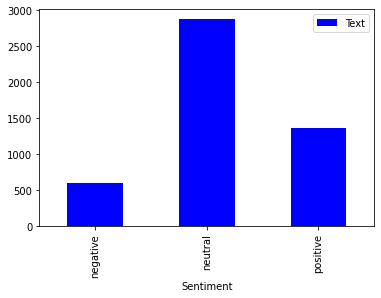

In [5]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'blue')

## VADER model

In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
predicted_sentiments = []
for text in df['Text']:
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.1:
        predicted_sentiments.append('positive')
    elif score['compound'] <= -0.1:
        predicted_sentiments.append('negative')
    else:
        predicted_sentiments.append('neutral')

df['predicted_sia'] = predicted_sentiments

In [8]:
df

,Sentiment,Text,predicted_sia
0,neutral,"According to Gran , the company has no plans t...",negative
1,neutral,Technopolis plans to develop in stages an area...,negative
2,negative,The international electronic industry company ...,neutral
3,positive,With the new production plant the company woul...,positive
4,positive,According to the company 's updated strategy f...,positive
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive
4844,negative,Net sales of the Paper segment decreased to EU...,positive


<AxesSubplot:xlabel='predicted_sia'>

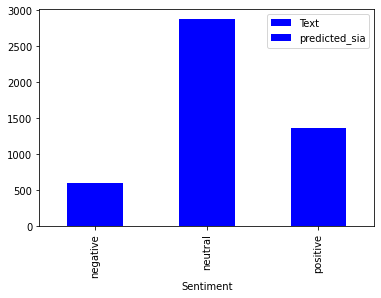

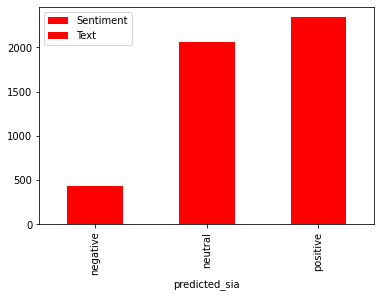

In [9]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'blue')
df.groupby('predicted_sia').count().plot(kind='bar',color = 'red')

## ProsusAI

In [10]:
X = df['Text'].to_list()
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [11]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [12]:
df['predicted_finbert'] = preds

In [13]:
df

,Sentiment,Text,predicted_sia,predicted_finbert
0,neutral,"According to Gran , the company has no plans t...",negative,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral
2,negative,The international electronic industry company ...,neutral,negative
3,positive,With the new production plant the company woul...,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative


<AxesSubplot:xlabel='predicted_finbert'>

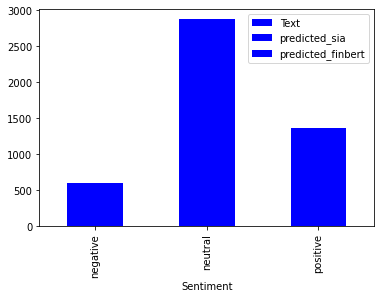

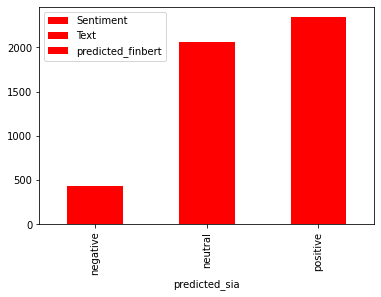

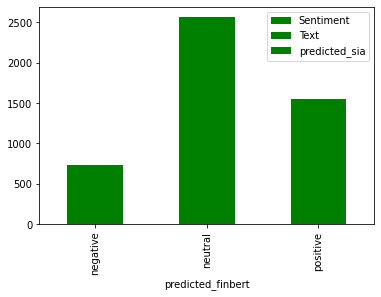

In [14]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'blue')
df.groupby('predicted_sia').count().plot(kind='bar',color = 'red')
df.groupby('predicted_finbert').count().plot(kind='bar',color = 'green')

## Textblob

In [18]:
import textblob
from textblob import TextBlob

In [19]:
polarity = []
polarity_type = []
def get_blob_sentiment(sentence):
    result = TextBlob(sentence).sentiment
    return result.polarity
for review in range(len(df)):
    sentiment = get_blob_sentiment(df['Text'][review])
    polarity.append(sentiment)
for i in range(len(polarity)):
    if polarity[i] > 0.1:
        polarity_type.append('positive')
    elif polarity[i] < -0.1:
        polarity_type.append('negative')
    else:
        polarity_type.append('neutral')
df['predicted_blob'] = polarity_type

In [20]:
df

,Sentiment,Text,predicted_sia,predicted_finbert,predicted_blob
0,neutral,"According to Gran , the company has no plans t...",negative,neutral,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral,neutral
2,negative,The international electronic industry company ...,neutral,negative,neutral
3,positive,With the new production plant the company woul...,positive,positive,neutral
4,positive,According to the company 's updated strategy f...,positive,positive,neutral
...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative,neutral
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative,neutral


<AxesSubplot:xlabel='predicted_blob'>

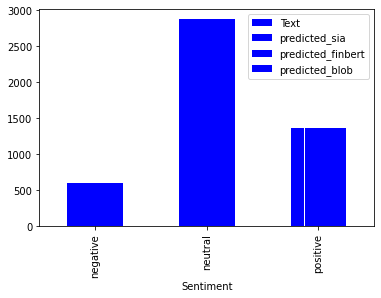

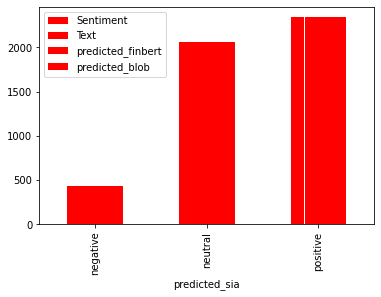

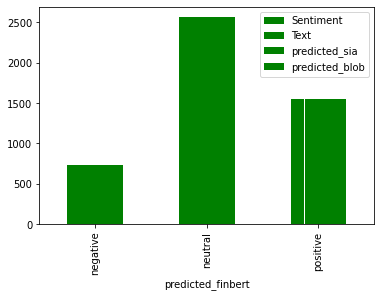

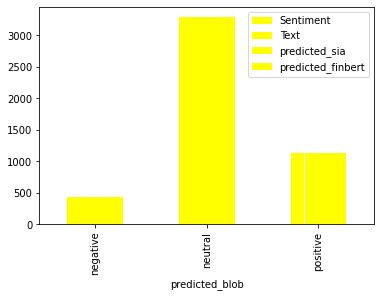

In [23]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'blue')
df.groupby('predicted_sia').count().plot(kind='bar',color = 'red')
df.groupby('predicted_finbert').count().plot(kind='bar',color = 'green')
df.groupby('predicted_blob').count().plot(kind='bar',color = 'yellow')

## Model Evaluation

In [24]:
y = df['Sentiment'].to_list()

## def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name}  Accuracy: {accuracy}')

evaluate_model_accuracy('VADER method', predicted_sentiments)
evaluate_model_accuracy('ProsusAI', preds)
evaluate_model_accuracy('Textblob', polarity_type)

In [36]:
print('Report VADER method')
print(classification_report(y,predicted_sentiments))
print('-------')
print('Report ProsusAI')
print(classification_report(y,preds))
print('-------')
print('Report Textblob')
print(classification_report(y,polarity_type))
print('-------')

Report VADER method
              precision    recall  f1-score   support

    negative       0.41      0.29      0.34       604
     neutral       0.74      0.53      0.62      2879
    positive       0.41      0.70      0.51      1363

    accuracy                           0.55      4846
   macro avg       0.52      0.51      0.49      4846
weighted avg       0.60      0.55      0.55      4846

-------
Report ProsusAI
              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2879
    positive       0.81      0.92      0.86      1363

    accuracy                           0.89      4846
   macro avg       0.86      0.92      0.88      4846
weighted avg       0.90      0.89      0.89      4846

-------
Report Textblob
              precision    recall  f1-score   support

    negative       0.34      0.24      0.28       604
     neutral       0.62      0.71      0.66      2879
    pos

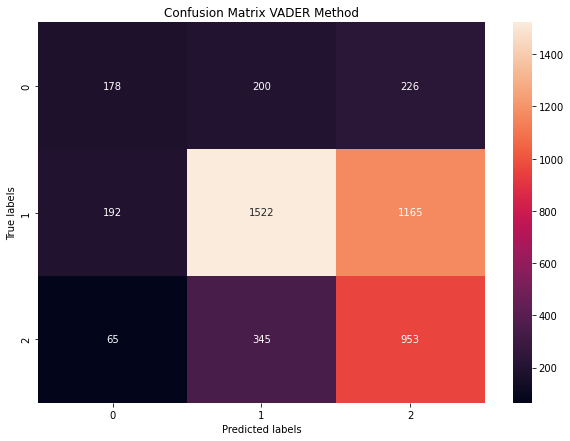

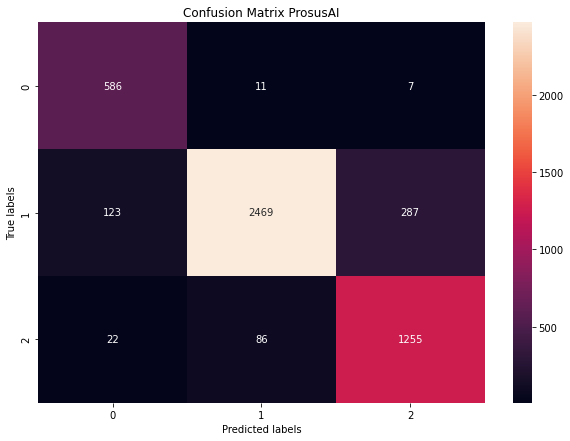

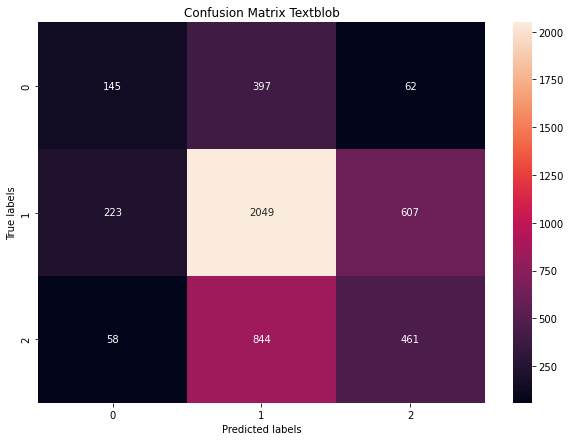

In [37]:
cm = confusion_matrix(y, predicted_sentiments)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix VADER Method')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix ProsusAI')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

cm = confusion_matrix(y, polarity_type)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix Textblob')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()